# Betrayal Detection in Diplomacy

Diplomacy is a strategic board game with social deception elements. The game consists of phases where players may negotiate and betray each other. We will attempt to predict whether betrayal occurs based off of the messages that players send to each other.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report,confusion_matrix

# Basic Preprocessing

First we preprocess the dataset into a dataframe that is easier to interpret for exploration/training.

In Diplomacy, each game is divided into multiple phases called seasons. Within each season, players can communicate with each other to coordinate attacks. Every entry in the original dataset consists of a particular interaction between two players in a game, containing statistical data regarding their messages spread across all seasons.

Therefore, in our preprocessed dataframe we will aggregate all message data per each season of the game, as we are only concerned about whether or not there was a betrayal in the interaction for the game as a whole.

In [15]:
df = pd.read_json('diplomacy_data.json')
# entries represent an interaction between two players in a particular game, spread across
# all of the games seasons

data = [] # 2d array to hold processed data

# we create a new processed pandas dataframe based off of the old one
'''
Our processed data will contain the following structure:

ID | Betrayal (T/F) | victim # msgs | betrayer # msgs |
victim # sentences | betrayer # sentences |
victim # words | betrayer # words | victim avg words per msg | betrayer avg words per msg | 
victim # requests | betrayer # requests | victim avg politeness | betrayer avg politeness | 
victim neg sentiment proportion | victim neu sentiment proportion |
victim pos sentiment proportion| betrayer neg sentiment proportion  | 
betrayer neu sentiment proportion | betrayer pos sentiment proportion | 

Note that if no betrayal occurs, the 'betrayer' label indicates the other person in the interaction,
chosen arbitrarily.


'''

betrayals = df['betrayal']
game_session_seasons = df['seasons']

# create our new processed df

season2 = df['seasons'][7]

for season in season2:
    msgs = season['messages']['betrayer']
    for msg in msgs:
        print("sentences: ", msg['n_sentences'])
        print(msg['sentiment'])

for i, seasons in enumerate(game_session_seasons):

    # print("new entry")
    
    entry = [] # represents a row of our new pandas dataframe

    # if this interaction is a betrayal
    betrayal = betrayals[i]
    entry.append(betrayal)

    # initialize all data that needs to be kept track of 
    v_msgs, b_msgs = 0, 0
    v_sentences, b_sentences = 0, 0
    v_words, b_words = 0, 0
    v_words_per_msg, b_words_per_msg = 0, 0
    v_requests, b_requests = 0, 0
    v_avg_polite, b_avg_polite = 0, 0
    v_neg_perc, b_neg_perc = 0, 0
    v_net_perc, b_net_perc = 0, 0
    v_pos_perc, b_pos_perc = 0, 0

    for season in seasons:
        # print(season)

        v_msg_list = season['messages']['victim']
        b_msg_list = season['messages']['betrayer']

        if len(v_msg_list) > 0:
            v_msgs += len(v_msg_list)

            # track victim message stats
            for msg in v_msg_list:
                v_sentences += msg['n_sentences']
                v_words += msg['n_words']
                v_requests += msg['n_requests']
                v_avg_polite += msg['politeness']
                v_neg_perc += msg['sentiment']['negative']
                v_net_perc += msg['sentiment']['neutral']
                v_pos_perc += msg['sentiment']['positive']
                
                
        if len(b_msg_list) > 0:
            b_msgs += len(b_msg_list)

            # track betrayer message stats
            for msg in b_msg_list:
                b_sentences += msg['n_sentences']
                b_words += msg['n_words']
                b_requests += msg['n_requests']
                b_avg_polite += msg['politeness']
                b_neg_perc += msg['sentiment']['negative']
                b_net_perc += msg['sentiment']['neutral']
                b_pos_perc += msg['sentiment']['positive']
                
    entry.append(v_msgs) # total amount of victim msgs for all seasons in this entry
    entry.append(b_msgs)
    
    entry.append(v_sentences)
    entry.append(b_sentences)
    
    entry.append(v_words)
    entry.append(b_words)
    
    if v_msgs != 0:
        v_words_per_msg = v_words/v_msgs
    
    if b_msgs != 0:
        b_words_per_msg = b_words/b_msgs
    
    # remove entries with no conversation
    if v_msgs == 0 and b_msgs == 0:
        continue
    
    entry.append(v_words_per_msg)
    entry.append(b_words_per_msg)
    
    entry.append(v_requests)
    entry.append(b_requests)
    
    if v_msgs != 0:
        v_avg_polite = v_avg_polite/v_msgs
        
    if b_msgs != 0:
        b_avg_polite = b_avg_polite/b_msgs
        
    entry.append(v_avg_polite)
    entry.append(b_avg_polite)
        
    if v_sentences != 0:
        v_neg_perc = v_neg_perc/v_sentences
        v_net_perc = v_net_perc/v_sentences
        v_pos_perc = v_pos_perc/v_sentences
        
    entry.append(v_neg_perc)
    entry.append(v_net_perc)
    entry.append(v_pos_perc)
    
    if b_sentences != 0:
        b_neg_perc = b_neg_perc/b_sentences
        b_net_perc = b_net_perc/b_sentences
        b_pos_perc = b_pos_perc/b_sentences
        
    entry.append(b_neg_perc)
    entry.append(b_net_perc)
    entry.append(b_pos_perc)
    
    data.append(entry)

print(len(data))

# create a new dataframe of our processed data
columns = ['betrayal', 'victim_msgs', 'betrayer_msgs', 'victim_sentences', 'betrayer_sentences', 
           'victim_words', 'betrayer_words', 'victim_words_per_msg', 'betrayer_words_per_msg',
          'victim_reqs', 'betrayer_reqs', 'victim_avg_polite', 'betrayer_avg_polite',
          'victim_neg_perc', 'victim_neu_perc', 'victim_pos_perc', 'betrayer_neg_perc',
          'betrayer_neu_perc', 'betrayer_pos_perc']

new_df = pd.DataFrame(data, columns=columns)
print(len(new_df))
# print(new_df)
new_df.to_csv('447processed.csv')

sentences:  2
{'positive': 1, 'neutral': 1, 'negative': 0}
sentences:  2
{'positive': 0, 'neutral': 2, 'negative': 0}
410
410


<h1> Data Exploration </h1>

As mentioned previously, Diplomacy is a strategic board game primarily based around negotiation. Players control one of the seven major powers from the early 20th century, such as Austria-Hungary, Germany, France, Great Britain, etc. The nature of negotation draws the natural conclusion similarly seen in nature, symbiosis. Players may want to have a mutualistic relationship, where they will both benefit, or, they may wish to take at someone else's expense. Hence, deception is also a major component of Diplomacy. You could promise another player your support in a battle, and then on the next movement opportunity, decide to attack them instead, costing them valuable resources, or even the game. This leads to a very complicated and delicate balance which we attempt to describe by using prediction algorithms with data taken from games played.

In [16]:
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   betrayal                410 non-null    bool   
 1   victim_msgs             410 non-null    int64  
 2   betrayer_msgs           410 non-null    int64  
 3   victim_sentences        410 non-null    int64  
 4   betrayer_sentences      410 non-null    int64  
 5   victim_words            410 non-null    int64  
 6   betrayer_words          410 non-null    int64  
 7   victim_words_per_msg    410 non-null    float64
 8   betrayer_words_per_msg  410 non-null    float64
 9   victim_reqs             410 non-null    int64  
 10  betrayer_reqs           410 non-null    int64  
 11  victim_avg_polite       410 non-null    float64
 12  betrayer_avg_polite     410 non-null    float64
 13  victim_neg_perc         410 non-null    float64
 14  victim_neu_perc         410 non-null    fl

In [17]:
X=new_df.drop(columns=["betrayal"],axis=1)
y=new_df["betrayal"]
display(X)
display(y)

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc
0,20,30,112,108,1451,2104,72.550000,70.133333,39,83,0.670067,0.730269,0.544643,0.276786,0.178571,0.472222,0.296296,0.231481
1,5,8,12,11,112,101,22.400000,12.625000,4,6,0.493841,0.464686,0.416667,0.500000,0.083333,0.636364,0.363636,0.000000
2,10,11,21,27,368,687,36.800000,62.454545,9,12,0.413216,0.542905,0.571429,0.333333,0.095238,0.666667,0.222222,0.111111
3,13,8,79,42,1552,802,119.384615,100.250000,54,28,0.696893,0.600306,0.569620,0.202532,0.227848,0.595238,0.238095,0.166667
4,6,9,21,29,234,344,39.000000,38.222222,18,13,0.554372,0.663111,0.428571,0.333333,0.238095,0.344828,0.413793,0.241379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,4,9,12,69,154,1242,38.500000,138.000000,4,37,0.702379,0.832442,0.416667,0.333333,0.250000,0.565217,0.289855,0.144928
406,14,13,135,127,1994,2385,142.428571,183.461538,47,58,0.691033,0.698891,0.548148,0.281481,0.170370,0.425197,0.275591,0.299213
407,13,9,48,61,607,923,46.692308,102.555556,25,37,0.740740,0.646064,0.541667,0.312500,0.145833,0.442623,0.377049,0.180328
408,28,21,184,173,2308,3016,82.428571,143.619048,71,72,0.580438,0.535524,0.445652,0.418478,0.135870,0.578035,0.260116,0.161850


0       True
1      False
2      False
3      False
4      False
       ...  
405    False
406     True
407     True
408     True
409     True
Name: betrayal, Length: 410, dtype: bool

In [18]:
X.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,11.329268,12.231707,70.541463,76.319512,1056.229268,1136.390244,74.423966,70.699029,34.173171,37.043902,0.618767,0.633118,0.475374,0.330035,0.150689,0.467768,0.341860,0.165982
std,12.691617,14.556440,107.303739,125.472029,1817.679823,2089.910238,63.431577,48.254030,53.879897,63.615848,0.179638,0.157176,0.185976,0.162794,0.106027,0.172909,0.166082,0.102112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,12.000000,14.000000,158.750000,163.250000,33.812500,35.500000,5.000000,6.000000,0.555541,0.566223,0.401010,0.250000,0.095326,0.400000,0.257033,0.109596
50%,8.000000,9.000000,37.000000,41.000000,506.500000,532.500000,60.656250,62.333333,18.000000,19.000000,0.644051,0.656107,0.498555,0.322581,0.151026,0.486833,0.333333,0.166667
75%,14.000000,15.000000,79.750000,87.750000,1192.000000,1219.250000,93.889286,90.587798,38.000000,41.750000,0.732000,0.730070,0.576010,0.415441,0.200000,0.555556,0.411706,0.220909
max,91.000000,125.000000,936.000000,1159.000000,17181.000000,23293.000000,668.000000,344.976744,416.000000,596.000000,0.937184,0.940893,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000


In [19]:
y.describe()

count       410
unique        2
top       False
freq        206
Name: betrayal, dtype: object

Unfortunately, we can't really see any trends yet, as if the "Betrayal" column is false, the betrayal data isn't very relevant. Let's take out the rows with Betrayal as "False" and see the new described data.

In [54]:
drop_df = new_df.drop(new_df[new_df.betrayal == "True"].index)
drop_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,11.436275,12.686275,73.901961,81.161765,1113.078431,1171.063725,75.935073,72.769813,35.156863,39.132353,0.623415,0.643633,0.469130,0.339318,0.157238,0.466370,0.332034,0.181988
std,12.354806,14.514121,115.529879,122.273852,2033.683041,1867.616381,69.718736,47.466178,55.602609,61.930178,0.166058,0.151691,0.189309,0.164881,0.104043,0.168043,0.157086,0.102703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,11.000000,17.000000,155.000000,179.750000,31.321429,36.587500,5.000000,8.000000,0.561158,0.583333,0.400000,0.262024,0.101751,0.400000,0.256343,0.126489
50%,9.000000,9.000000,38.500000,46.500000,548.000000,581.500000,61.062500,64.944444,19.000000,21.000000,0.640927,0.664437,0.484360,0.332184,0.153846,0.483046,0.326136,0.176671
75%,14.000000,16.000000,86.250000,100.000000,1187.750000,1370.000000,93.680288,94.052083,39.000000,47.000000,0.725273,0.735732,0.561543,0.418697,0.204740,0.543219,0.381952,0.231787
max,91.000000,125.000000,936.000000,1123.000000,17181.000000,14834.000000,668.000000,344.976744,416.000000,596.000000,0.937184,0.929327,1.000000,1.000000,0.666667,1.000000,1.000000,0.600000


Let's take a look at these graphically.

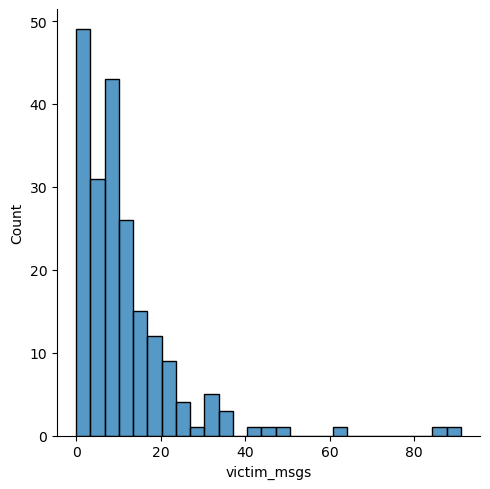

In [55]:
z = sns.displot(drop_df['victim_msgs']);
plt.show(z)

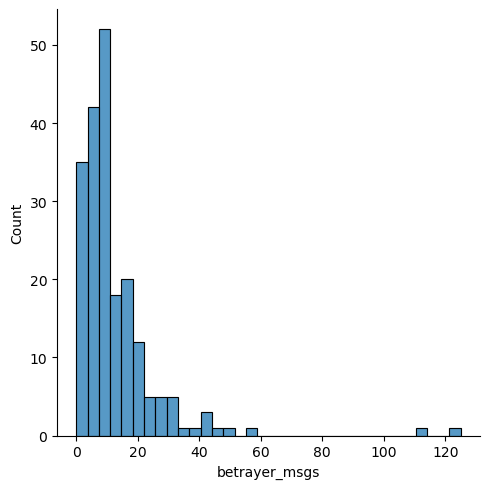

In [56]:
z = sns.displot(drop_df['betrayer_msgs']);
plt.show(z)

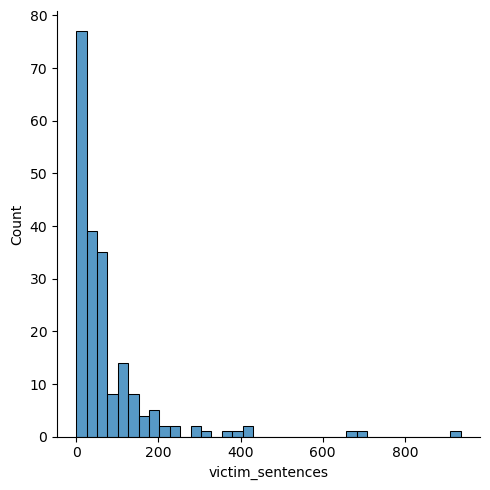

In [57]:
z = sns.displot(drop_df['victim_sentences']);
plt.show(z)

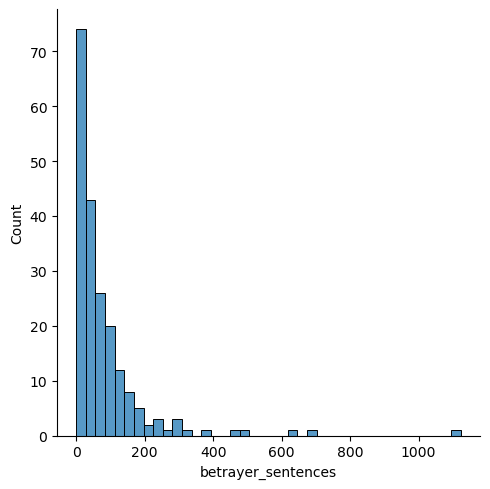

In [58]:
z = sns.displot(drop_df['betrayer_sentences']);
plt.show(z)

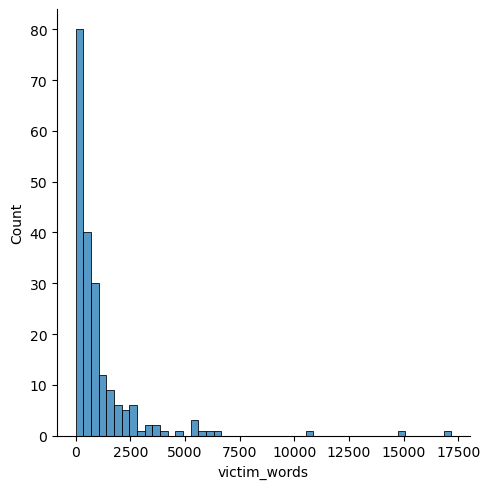

In [59]:
z = sns.displot(drop_df['victim_words']);
plt.show(z)

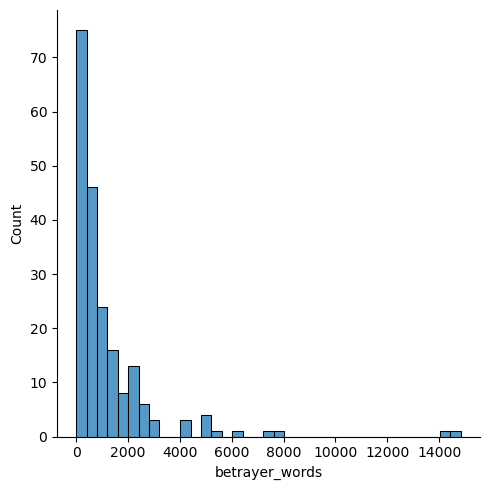

In [60]:
z = sns.displot(drop_df['betrayer_words']);
plt.show(z)

Graphically, it is not very easy to see very much difference.

In [63]:
drop_df.describe()

,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,11.436275,12.686275,73.901961,81.161765,1113.078431,1171.063725,75.935073,72.769813,35.156863,39.132353,0.623415,0.643633,0.469130,0.339318,0.157238,0.466370,0.332034,0.181988
std,12.354806,14.514121,115.529879,122.273852,2033.683041,1867.616381,69.718736,47.466178,55.602609,61.930178,0.166058,0.151691,0.189309,0.164881,0.104043,0.168043,0.157086,0.102703
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,11.000000,17.000000,155.000000,179.750000,31.321429,36.587500,5.000000,8.000000,0.561158,0.583333,0.400000,0.262024,0.101751,0.400000,0.256343,0.126489
50%,9.000000,9.000000,38.500000,46.500000,548.000000,581.500000,61.062500,64.944444,19.000000,21.000000,0.640927,0.664437,0.484360,0.332184,0.153846,0.483046,0.326136,0.176671
75%,14.000000,16.000000,86.250000,100.000000,1187.750000,1370.000000,93.680288,94.052083,39.000000,47.000000,0.725273,0.735732,0.561543,0.418697,0.204740,0.543219,0.381952,0.231787
max,91.000000,125.000000,936.000000,1123.000000,17181.000000,14834.000000,668.000000,344.976744,416.000000,596.000000,0.937184,0.929327,1.000000,1.000000,0.666667,1.000000,1.000000,0.600000


Taking a look at our data again, let's take a look at the number of requests, the average "politeness" they had towards one another, and the proportion of negatively, neutrally, or positively perceived messages. Betrayers make more requests on average, and are slightly more polite. What is also interesting is the very large proportion of negatively perceived messages on both sides. Seldomly do people interpret anothers message as positive, but the betrayer's on average do it more.

Lets look at these graphically.

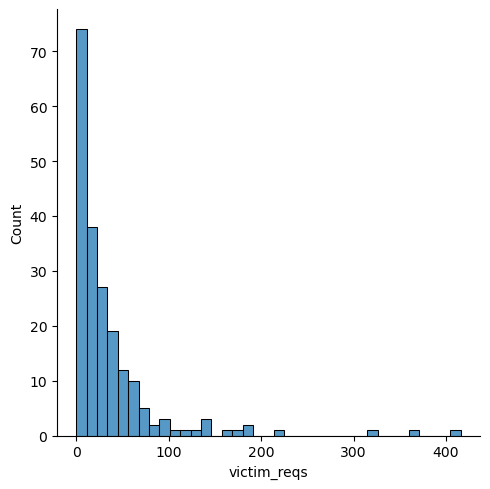

In [64]:
z = sns.displot(drop_df['victim_reqs']);
plt.show(z)

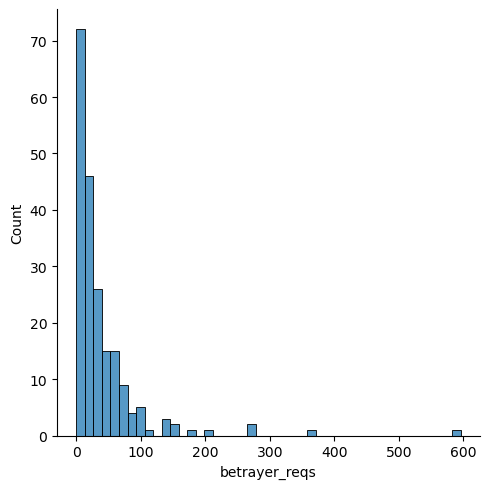

In [65]:
z = sns.displot(drop_df['betrayer_reqs']);
plt.show(z)

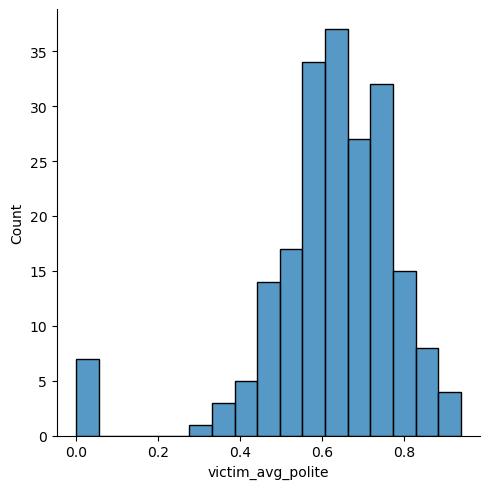

In [66]:

z = sns.displot(drop_df['victim_avg_polite']);
plt.show(z)

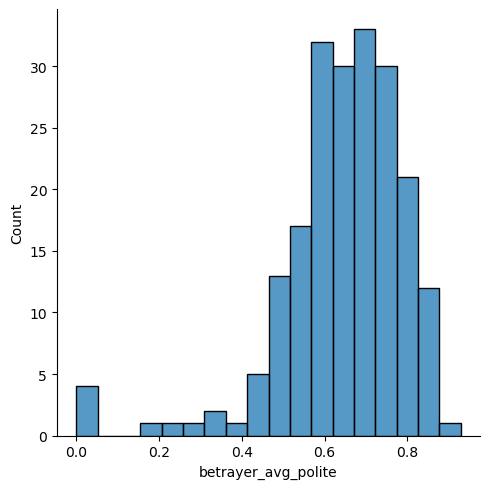

In [67]:

z = sns.displot(drop_df['betrayer_avg_polite']);
plt.show(z)

<h2> Heatmap </h2>

In [68]:
drop_df.style.background_gradient(cmap='Blues')

,betrayal,victim_msgs,betrayer_msgs,victim_sentences,betrayer_sentences,victim_words,betrayer_words,victim_words_per_msg,betrayer_words_per_msg,victim_reqs,betrayer_reqs,victim_avg_polite,betrayer_avg_polite,victim_neg_perc,victim_neu_perc,victim_pos_perc,betrayer_neg_perc,betrayer_neu_perc,betrayer_pos_perc
0,True,20,30,112,108,1451,2104,72.550000,70.133333,39,83,0.670067,0.730269,0.544643,0.276786,0.178571,0.472222,0.296296,0.231481
5,True,17,20,108,121,1489,1697,87.588235,84.850000,53,46,0.645001,0.683075,0.462963,0.333333,0.203704,0.446281,0.272727,0.280992
8,True,4,9,8,25,47,236,11.750000,26.222222,3,12,0.514394,0.586314,0.125000,0.500000,0.375000,0.400000,0.360000,0.240000
9,True,6,4,11,12,133,121,22.166667,30.250000,10,5,0.552583,0.598440,0.272727,0.727273,0.000000,0.500000,0.250000,0.250000
10,True,5,5,26,17,286,209,57.200000,41.800000,8,10,0.576615,0.564996,0.423077,0.423077,0.153846,0.529412,0.352941,0.117647
13,True,5,2,71,4,1427,57,285.400000,28.500000,35,2,0.832871,0.691985,0.647887,0.169014,0.183099,0.500000,0.000000,0.500000
16,True,3,2,10,5,135,50,45.000000,25.000000,5,2,0.756535,0.657743,0.400000,0.500000,0.100000,0.400000,0.400000,0.200000
17,True,14,18,31,102,440,994,31.428571,55.222222,17,57,0.674956,0.752240,0.580645,0.290323,0.129032,0.333333,0.470588,0.196078
18,True,8,10,26,70,402,1280,50.250000,128.000000,16,39,0.531206,0.799682,0.576923,0.269231,0.153846,0.600000,0.242857,0.157143
20,True,8,9,94,96,1297,1221,162.125000,135.666667,57,34,0.628772,0.775977,0.500000,0.276596,0.223404,0.489583,0.312500,0.197917


<h2> Correlation </h2>

Let us get the correlation between features in the dataset.

In [69]:
#correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

Messages, sentences and words are very correlated to one another. This makes sense, if you have more messages you have more words, and then you have more sentences. Nothing else stands out too much though.

Lets attempt to gather feature relevancy through P-scores.

In [70]:
from scipy.stats import chi2_contingency

print("Index P-values: ")
for index in X.keys():
    tmp = pd.crosstab(X[index], y)
    result = chi2_contingency(tmp)
    
    print("Index " + index + " P-Value: " + str(result[1]))

Index P-values: 
Index victim_msgs P-Value: 0.6281360431587037
Index betrayer_msgs P-Value: 0.6421009894287186
Index victim_sentences P-Value: 0.3029083228395732
Index betrayer_sentences P-Value: 0.41308010599671946
Index victim_words P-Value: 0.5016998876152111
Index betrayer_words P-Value: 0.3397315353108869
Index victim_words_per_msg P-Value: 0.5510264052797148
Index betrayer_words_per_msg P-Value: 0.43061250545625235
Index victim_reqs P-Value: 0.4014805234341584
Index betrayer_reqs P-Value: 0.2136857040874243
Index victim_avg_polite P-Value: 0.4778638917916376
Index betrayer_avg_polite P-Value: 0.4849632593134492
Index victim_neg_perc P-Value: 0.23726635942949453
Index victim_neu_perc P-Value: 0.41566404174739324
Index victim_pos_perc P-Value: 0.4113470440499891
Index betrayer_neg_perc P-Value: 0.3043985029830363
Index betrayer_neu_perc P-Value: 0.23823929243444433
Index betrayer_pos_perc P-Value: 0.36343139335899627


Seemingly very little correlation between any of the features and the target, betrayal. We can get some poor certainty, around 60-80%, but let's try with some different methods and see how that describes the feature space.

In [71]:
for col in X:
    print(col + "'s pearson correlation to betrayal: " + str(X[col].corr(y)))

victim_msgs's pearson correlation to betrayal: 0.008400474328686944
betrayer_msgs's pearson correlation to betrayal: 0.03111391503344101
victim_sentences's pearson correlation to betrayal: 0.031203294667748398
betrayer_sentences's pearson correlation to betrayal: 0.03845140897262833
victim_words's pearson correlation to betrayal: 0.031161505900118996
betrayer_words's pearson correlation to betrayal: 0.016530331618914106
victim_words_per_msg's pearson correlation to betrayal: 0.02373567917425894
betrayer_words_per_msg's pearson correlation to betrayal: 0.042757551073620836
victim_reqs's pearson correlation to betrayal: 0.01819047908787643
betrayer_reqs's pearson correlation to betrayal: 0.032709252297871264
victim_avg_polite's pearson correlation to betrayal: 0.025779525058915856
betrayer_avg_polite's pearson correlation to betrayal: 0.06665495344709092
victim_neg_perc's pearson correlation to betrayal: -0.03344904165579314
victim_neu_perc's pearson correlation to betrayal: 0.0568179840

Again, very little correlation between any of the features and the target, betrayal.

Let's try with some different correlation methods.

In [72]:
for col in X:
    print(col + "'s spearman correlation to betrayal: " + str(X[col].corr(y, method='spearman')))

victim_msgs's spearman correlation to betrayal: 0.022016855152858818
betrayer_msgs's spearman correlation to betrayal: 0.07422727330388479
victim_sentences's spearman correlation to betrayal: 0.01976501597956776
betrayer_sentences's spearman correlation to betrayal: 0.10265527783679783
victim_words's spearman correlation to betrayal: 0.012097251649378018
betrayer_words's spearman correlation to betrayal: 0.08220490898222467
victim_words_per_msg's spearman correlation to betrayal: 0.003977459548941853
betrayer_words_per_msg's spearman correlation to betrayal: 0.06740845219459456
victim_reqs's spearman correlation to betrayal: 0.010101526478708952
betrayer_reqs's spearman correlation to betrayal: 0.10521212277260068
victim_avg_polite's spearman correlation to betrayal: -0.014281733408237986
betrayer_avg_polite's spearman correlation to betrayal: 0.07554834385948422
victim_neg_perc's spearman correlation to betrayal: -0.061298050425473476
victim_neu_perc's spearman correlation to betrayal

In [73]:
for col in X:
    print(col + "'s kendall correlation to betrayal: " + str(X[col].corr(y, method='kendall')))

victim_msgs's kendall correlation to betrayal: 0.01837859453564464
betrayer_msgs's kendall correlation to betrayal: 0.06194782379874699
victim_sentences's kendall correlation to betrayal: 0.016233732981342917
betrayer_sentences's kendall correlation to betrayal: 0.08427005654005895
victim_words's kendall correlation to betrayal: 0.009900661731440023
betrayer_words's kendall correlation to betrayal: 0.0672416701524242
victim_words_per_msg's kendall correlation to betrayal: 0.003255029105357289
betrayer_words_per_msg's kendall correlation to betrayal: 0.05513686069066876
victim_reqs's kendall correlation to betrayal: 0.00833733645894388
betrayer_reqs's kendall correlation to betrayal: 0.08675158909196715
victim_avg_polite's kendall correlation to betrayal: -0.011685372671379752
betrayer_avg_polite's kendall correlation to betrayal: 0.061776280668027705
victim_neg_perc's kendall correlation to betrayal: -0.050307463269054546
victim_neu_perc's kendall correlation to betrayal: 0.05654736297

Still, not very much to go off of. It realistically seems that many of the features collected in the dataset do not correlate very well to betrayal. However, I would not say that is the fault of the dataset, but moreso the premise of the problem. There are many issues with calculating and predicting deception or lying. 

According to the American Psychological Association (<a href="https://www.apa.org/topics/cognitive-neuroscience/polygraph#:~:text=The%20accuracy%20(i.e.%2C%20validity),person%20may%20be%20non%2Danxious">Truth about Lie Detectors</a>), there is very little evidence that even polygraph tests can detect lies. Obviously there are some general trends, for example, a liar might speak too much or speak too little. Liars may use particular words, or they may avoid certain words. But this is on a case by case basis, and these generalities are too vague and too loose to actually be applied in a real world scenario. Imagine being convicted of a crime, because a machine learning model predicted that you were. This goes heavily into the ethics of these applications, which I hope our project can demonstrate. Predicting lying can have devastating consequences.